In [1]:
import os
import logging
import imageio
import numpy as np
import exercise5
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [2]:
def exact_solution(x, t, nu):
    return x / (1 + 4 * nu * t)**(3/2) * np.exp(-x**2 / (1 + 4 * nu * t))

In [3]:
N = [50, 100, 200, 400, 800]
M = 32
X = 4
T = 10

dx = 2*X/M
dt = 0.1
d = 1
nu = 0.0001


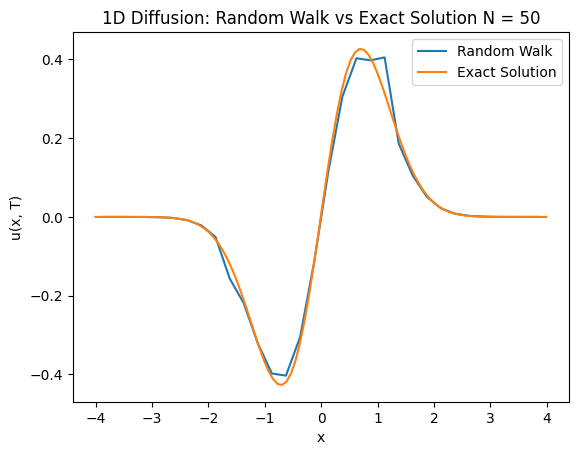

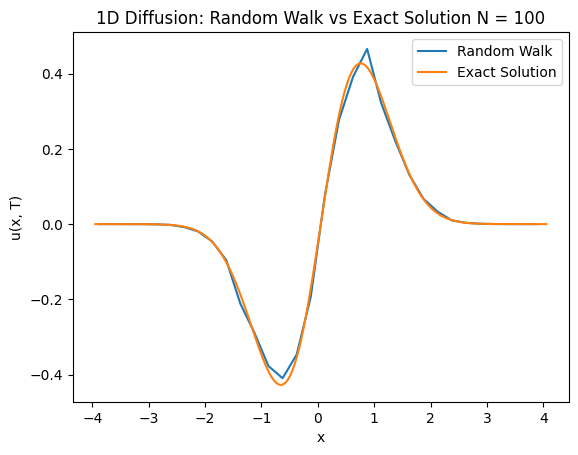

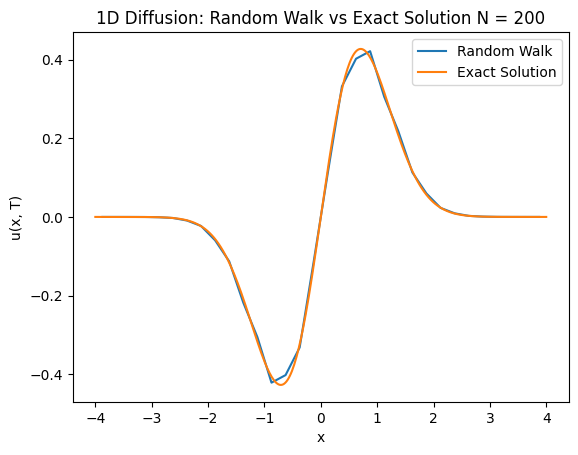

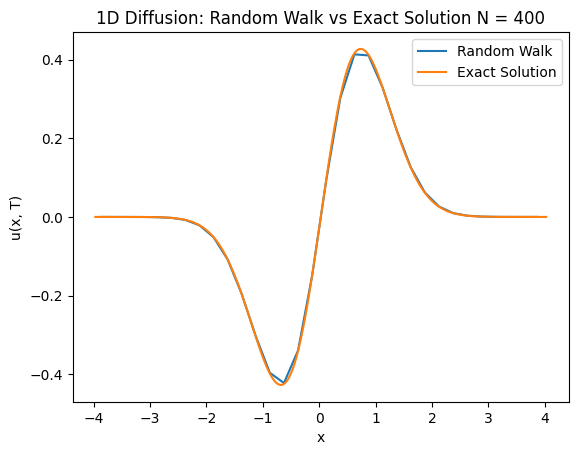

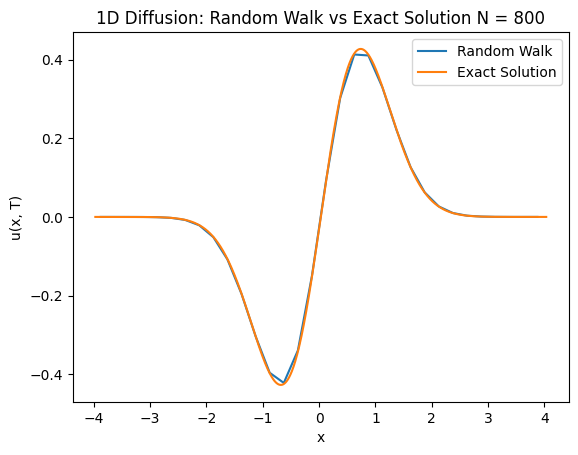

In [8]:
for n in N:
    h = 2*X/(2*n-1)
    positions = np.linspace(-X, X, 2*n)
    u_exact = exact_solution(positions, T, nu) 
    omega_0 = h*positions*np.exp(-positions**2)
    for _ in np.arange(0, T, dt):
        positions += np.random.normal(0, np.sqrt(d*nu*dt))
    # plt.scatter(x, np.zeros_like(x), marker = '|')
    # plt.show()
    u_RW = [0] * int(M)
    edges = np.arange(-X, X + dx, dx)
    xbin = (edges[:-1] + edges[1:]) / 2
    for i, bin in enumerate(np.arange(-X + dx, X + dx, dx)):
        # x > 0 for boundary condition
        # u_RW[i] = 1/dx*sum(omega_0[np.where((x > bin - dx) & (x <= bin) & (x > 0))[0]])
        u_RW[i] = 1/dx*sum(omega_0[np.where((positions > bin - dx) & (positions <= bin))[0]])
    plt.plot(xbin, u_RW, label='Random Walk')
    plt.plot(positions, u_exact, label='Exact Solution')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('u(x, T)')
    plt.title(f'1D Diffusion: Random Walk vs Exact Solution N = {n}')
    plt.show()


In [18]:
# %%writefile -a exercise6.py

def eta_epsilon(r, epsilon):
    return np.exp(-r**2 / (4 * epsilon**2)) / np.sqrt(4 * np.pi * epsilon**2)

def eta_epsilon_2d(r, epsilon):
    return np.exp(-r**2 / (epsilon**2)) * 4 / (np.pi * epsilon**2)

def pse_diffusion_1d(D, epsilon, u, x, verlet, N, V):
    du = np.zeros_like(u)
    for p in range(N):
        for q in verlet[p]:
            du[p] += (u[q] - u[p])*eta_epsilon(x[q] - x[p], epsilon)*V[q]
    return V*D/epsilon**2*du

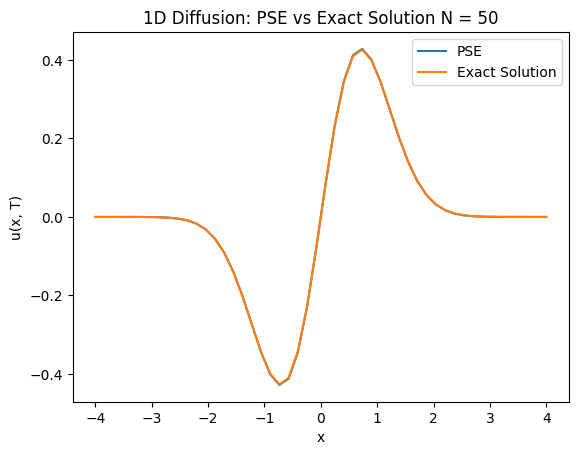

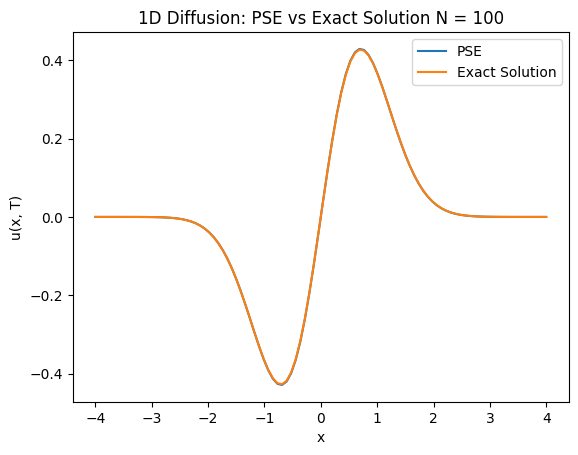

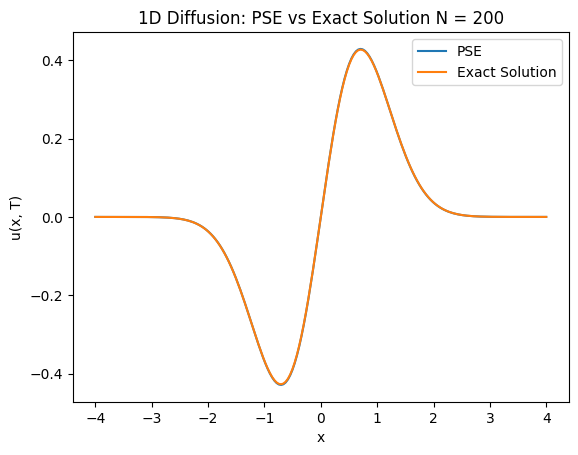

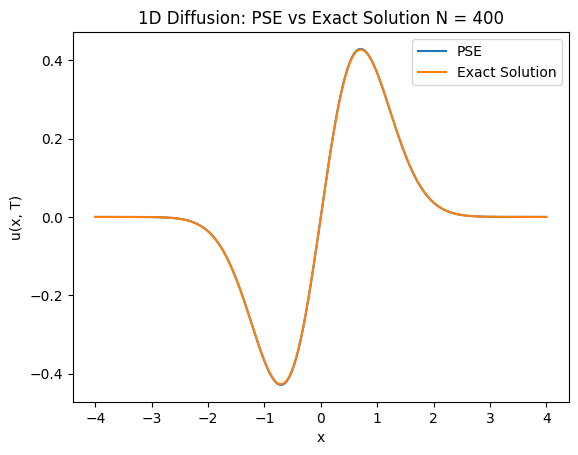

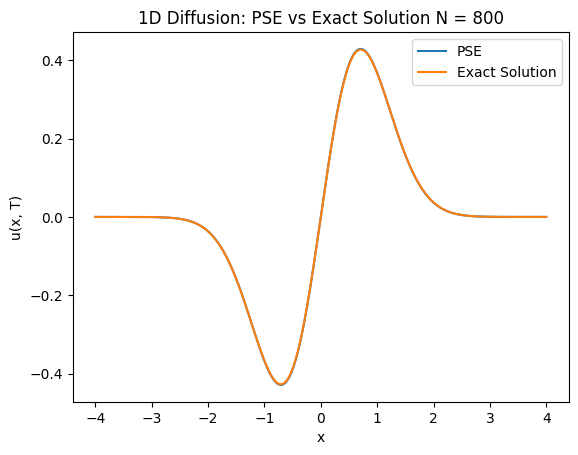

In [7]:
cell_side = cutoff = 2
for n in N:
    h = 2*X/(2*n-1)
    V = np.ones(n)*h**2
    epsilon = h
    positions = np.linspace(-X, X, n)
    u_exact = exact_solution(positions, T, nu) 
    u_PSE = positions*np.exp(-positions**2)
    particle_matrix, cell_list, num_cells = exercise5.get_cell_list_1d(positions, -X, X, cell_side)
    verlet = exercise5.get_verlet_list_1d(cell_list, particle_matrix, num_cells, cutoff)
    for t in np.arange(0, T, dt):
        du = pse_diffusion_1d(nu, epsilon, u_PSE, positions, verlet, n, V)
        u_PSE += du*dt
    plt.plot(positions, u_PSE, label='PSE')
    plt.plot(positions, u_exact, label='Exact Solution')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('u(x, T)')
    plt.title(f'1D Diffusion: PSE vs Exact Solution N = {n}')
    plt.show()

In [21]:
# %%writefile -a exercise6.py

def periodic_boundaries(u):
    u_reshaped = u.reshape((n, n))
    
    u_reshaped[:, 0] = u_reshaped[:, -2]
    u_reshaped[:, -1] = u_reshaped[:, 1]
    u_reshaped[0, :] = u_reshaped[-2, :]
    u_reshaped[-1, :] = u_reshaped[1, :]
    
    return u_reshaped.flatten()

In [22]:
# %%writefile -a exercise6.py

def pse_diffusion_2d(D, epsilon, u, positions, verlet, N, V):
    du = np.zeros_like(u)
    for p in range(N):
        for q in verlet[p]:
            r = np.linalg.norm(positions[q] - positions[p])
            du[p] += (u[q] - u[p])*eta_epsilon_2d(r, epsilon)*V[q]
    return V*D/epsilon**2*du

In [30]:
def diffuse_dirac(positions, D, t, init):
    _, dim = positions.shape
    particle_dists = np.sqrt(np.sum((positions - init) ** 2, axis=1))
    return np.exp(-(particle_dists ** 2) / (4 * D * t)) / ((4 * np.pi * D * t) ** (dim / 2))

In [12]:
n = 25

T = 0.5
nu = 2
l_bound, u_bound = 0, 1
h = (u_bound - l_bound) / ((n*n)**(1/2))
epsilon = h
cell_side = cutoff = 3*epsilon
dt = h**2/(3*nu)

x = np.linspace(l_bound, u_bound, n)
y = np.linspace(l_bound, u_bound, n)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T

particle_matrix, cell_list, num_cells = exercise5.get_cell_list_2d(positions, l_bound, u_bound, cell_side)
verlet = exercise5.get_verlet_list_2d(cell_list, particle_matrix, num_cells, cutoff)

frames_dir = "./Exercise6/frames_PSE"
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir) 

In [13]:
logging.info('Starting 2D diffusion simulation.')
u_PSE2d = np.zeros(len(positions))
idx = np.where(np.all(positions == np.array([0.25, 0.5]), axis=1))[0][0]
u_PSE2d[idx] = 150
V = np.ones_like(u_PSE2d)*h**2
iteration = 0
for t in np.arange(0, T, dt):
    logging.info(f'Starting iteration {iteration} at time {t:.4f}.')
    du = pse_diffusion_2d(nu, epsilon, u_PSE2d, positions, verlet, n*n, V)
    u_PSE2d += du*dt
    u_PSE2d = periodic_boundaries(u_PSE2d)
    if iteration % 5 == 0:
        plt.imshow(
            u_PSE2d.reshape(n, n), extent=[l_bound, u_bound, l_bound, u_bound], 
            origin='lower', cmap='viridis',
        )
        plt.colorbar(label='Concentration')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'2D Diffusion: PSE Method at t = {t:.4f}')

        filename = f"{frames_dir}/frame_{iteration:04d}.png"
        plt.savefig(filename)
        plt.close()
    iteration += 1

logging.info('Simulation completed.')

2024-07-02 15:48:04,238 - Starting 2D diffusion simulation.
2024-07-02 15:48:04,242 - Starting iteration 0 at time 0.0000.
2024-07-02 15:48:04,886 - Starting iteration 1 at time 0.0003.
2024-07-02 15:48:05,190 - Starting iteration 2 at time 0.0005.
2024-07-02 15:48:05,450 - Starting iteration 3 at time 0.0008.
2024-07-02 15:48:05,800 - Starting iteration 4 at time 0.0011.
2024-07-02 15:48:06,145 - Starting iteration 5 at time 0.0013.
2024-07-02 15:48:06,930 - Starting iteration 6 at time 0.0016.
2024-07-02 15:48:07,189 - Starting iteration 7 at time 0.0019.
2024-07-02 15:48:07,456 - Starting iteration 8 at time 0.0021.
2024-07-02 15:48:07,805 - Starting iteration 9 at time 0.0024.
2024-07-02 15:48:08,186 - Starting iteration 10 at time 0.0027.
2024-07-02 15:48:08,898 - Starting iteration 11 at time 0.0029.
2024-07-02 15:48:09,163 - Starting iteration 12 at time 0.0032.
2024-07-02 15:48:09,419 - Starting iteration 13 at time 0.0035.
2024-07-02 15:48:09,668 - Starting iteration 14 at tim

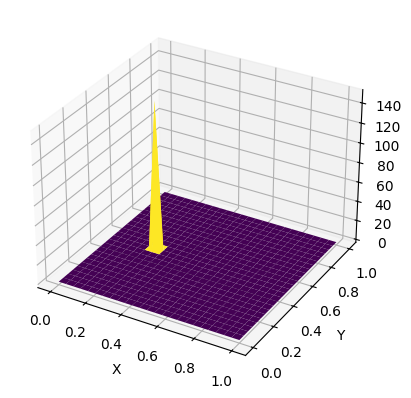

In [50]:
u_PSE2d = np.zeros(len(positions))
idx = np.where(np.all(positions == np.array([0.25, 0.5]), axis=1))[0][0]
u_PSE2d[idx] = 150

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_PSE2d.reshape(n, n), cmap='viridis')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('u')

plt.show()

In [14]:
def create_video(frames_dir, output_file, fps=10):
    images = []
    for file_name in sorted(os.listdir(frames_dir)):
        if file_name.endswith(".png"):
            file_path = os.path.join(frames_dir, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(output_file, images, fps=fps)

In [15]:
frames_dir = "./Exercise6/frames_PSE"
output_file = "./Exercise6/PSE.mp4"
create_video(frames_dir, output_file, fps=10)

C:\Users\79217\AppData\Local\Temp\ipykernel_12696\4000624477.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
